In [ ]:
!pip install tensorflow==2.15.*

In [ ]:
import tensorflow.compat.v1 as tf

In [ ]:
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
from ast import literal_eval
import time
import datetime
import os

#import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#movies_content = pd.read_csv('/content/drive/MyDrive/TP4/movies_metadata.csv').filter(items=['id','genres','original_title','release_date']).drop([19730, 29503, 35587])

movies = pd.read_csv('/content/drive/MyDrive/TP4/movies_metadata.csv').filter(items=['id','release_date','title','original_language','genres']).drop([19730, 29503, 35587])
movies['id'] = movies['id'].astype('int64')
movies.drop_duplicates(subset='id', keep='first', inplace=True)
movies.head()

,id,release_date,title,original_language,genres
0,862,1995-10-30,Toy Story,en,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '..."
1,8844,1995-12-15,Jumanji,en,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '..."
2,15602,1995-12-22,Grumpier Old Men,en,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ..."
3,31357,1995-12-22,Waiting to Exhale,en,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam..."
4,11862,1995-02-10,Father of the Bride Part II,en,"[{'id': 35, 'name': 'Comedy'}]"


In [ ]:
def get_text(text, obj='name'):
    text = literal_eval(text)

    if len(text) == 1:
        for i in text:
            return i[obj]
    else:
        s = []
        for i in text:
            s.append(i[obj])
        return ', '.join(s)

movies['genres'] = movies['genres'].apply(get_text)

movies.head()

,id,release_date,title,original_language,genres
0,862,1995-10-30,Toy Story,en,"Animation, Comedy, Family"
1,8844,1995-12-15,Jumanji,en,"Adventure, Fantasy, Family"
2,15602,1995-12-22,Grumpier Old Men,en,"Romance, Comedy"
3,31357,1995-12-22,Waiting to Exhale,en,"Comedy, Drama, Romance"
4,11862,1995-02-10,Father of the Bride Part II,en,Comedy


In [ ]:
# Check for empty cells
# Identify empty cells in the 'genres' column
empty_cells = movies['genres'].str.strip().eq('')

# Get the indices of empty cells
empty_indices = movies[empty_cells].index

print(empty_cells)

0        False
1        False
2        False
3        False
4        False
         ...  
45461    False
45462    False
45463    False
45464     True
45465     True
Name: genres, Length: 45433, dtype: bool


In [ ]:
# Fill empty cells in the 'genres' column with a specific value
specific_value = 'Unknown'

movies['genres'] = movies['genres'].replace('', specific_value)

In [ ]:

# Split the 'genres' column by comma and strip whitespace
split_genres = movies['genres'].str.split(',').apply(lambda x: [genre.strip() for genre in x])

# Collect all unique genres
distinct_genres = set(genre for sublist in split_genres for genre in sublist)

# Convert the set to a list if needed
genre_cols = list(distinct_genres)

print(genre_cols)

['Science Fiction', 'Drama', 'Horror', 'Romance', 'Comedy', 'Animation', 'Documentary', 'TV Movie', 'Family', 'Foreign', 'Action', 'Mystery', 'Unknown', 'Crime', 'History', 'Fantasy', 'Western', 'Thriller', 'Music', 'Adventure', 'War']


In [ ]:

# Add genre columns with 0 as values
movies = movies.assign(**{col: 0 for col in genre_cols})
movies.head()

,id,release_date,title,original_language,genres,Science Fiction,Drama,Horror,Romance,Comedy,...,Mystery,Unknown,Crime,History,Fantasy,Western,Thriller,Music,Adventure,War
0,862,1995-10-30,Toy Story,en,"Animation, Comedy, Family",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8844,1995-12-15,Jumanji,en,"Adventure, Fantasy, Family",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,15602,1995-12-22,Grumpier Old Men,en,"Romance, Comedy",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,31357,1995-12-22,Waiting to Exhale,en,"Comedy, Drama, Romance",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11862,1995-02-10,Father of the Bride Part II,en,Comedy,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Function to update the genre columns
def update_genre_columns(row):
    genres = row['genres'].split(', ')
    for genre in genres:
        if genre in genre_cols:
            row[genre] = 1
    return row

# Apply the function to update genre columns
movies = movies.apply(update_genre_columns, axis=1)
movies.head()

,id,release_date,title,original_language,genres,Science Fiction,Drama,Horror,Romance,Comedy,...,Mystery,Unknown,Crime,History,Fantasy,Western,Thriller,Music,Adventure,War
0,862,1995-10-30,Toy Story,en,"Animation, Comedy, Family",0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,8844,1995-12-15,Jumanji,en,"Adventure, Fantasy, Family",0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,15602,1995-12-22,Grumpier Old Men,en,"Romance, Comedy",0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,31357,1995-12-22,Waiting to Exhale,en,"Comedy, Drama, Romance",0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,11862,1995-02-10,Father of the Bride Part II,en,Comedy,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Function to map genres to their indices
def map_genres_to_indices(genres_str):
    genres = genres_str.split(', ')
    indices = [str(genre_cols.index(genre) + 1) for genre in genres]

    return ', '.join(indices)

# Create the 'all_genres' column
movies['all_genres'] = movies['genres'].apply(map_genres_to_indices)
movies.head()

,id,release_date,title,original_language,genres,Science Fiction,Drama,Horror,Romance,Comedy,...,Unknown,Crime,History,Fantasy,Western,Thriller,Music,Adventure,War,all_genres
0,862,1995-10-30,Toy Story,en,"Animation, Comedy, Family",0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,"6, 5, 9"
1,8844,1995-12-15,Jumanji,en,"Adventure, Fantasy, Family",0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,"20, 16, 9"
2,15602,1995-12-22,Grumpier Old Men,en,"Romance, Comedy",0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,"4, 5"
3,31357,1995-12-22,Waiting to Exhale,en,"Comedy, Drama, Romance",0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,"5, 2, 4"
4,11862,1995-02-10,Father of the Bride Part II,en,Comedy,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5


In [ ]:
# A subset of the ratings
ratings = pd.read_csv('/content/drive/MyDrive/TP4/ratings_small.csv').filter(items=['userId', 'movieId', 'rating', 'timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
# # all ratings
# ratings = pd.read_csv('/content/drive/MyDrive/TP4/ratings.csv').filter(items=['userId', 'movieId', 'rating', 'timestamp'])
# ratings.head()

In [ ]:
ratings

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


In [ ]:
# Since the ids start at 1, we shift them to start at 0.
#users["user_id"] = users["user_id"].apply(lambda x: str(x-1))
movies["movie_id"] = movies["id"].apply(lambda x: str(x-1))
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[0])

ratings["movie_id"] = ratings["movieId"].apply(lambda x: str(x-1))
ratings["user_id"] = ratings["userId"].apply(lambda x: str(x-1))
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

In [ ]:
movies.head()

,id,release_date,title,original_language,genres,Science Fiction,Drama,Horror,Romance,Comedy,...,History,Fantasy,Western,Thriller,Music,Adventure,War,all_genres,movie_id,year
0,862,1995-10-30,Toy Story,en,"Animation, Comedy, Family",0,0,0,0,1,...,0,0,0,0,0,0,0,"6, 5, 9",861,1995
1,8844,1995-12-15,Jumanji,en,"Adventure, Fantasy, Family",0,0,0,0,0,...,0,1,0,0,0,1,0,"20, 16, 9",8843,1995
2,15602,1995-12-22,Grumpier Old Men,en,"Romance, Comedy",0,0,0,1,1,...,0,0,0,0,0,0,0,"4, 5",15601,1995
3,31357,1995-12-22,Waiting to Exhale,en,"Comedy, Drama, Romance",0,1,0,1,1,...,0,0,0,0,0,0,0,"5, 2, 4",31356,1995
4,11862,1995-02-10,Father of the Bride Part II,en,Comedy,0,0,0,0,1,...,0,0,0,0,0,0,0,5,11861,1995


In [ ]:
movies = movies.rename(columns={'id': 'movieId'})
movies.head()

,movieId,release_date,title,original_language,genres,Science Fiction,Drama,Horror,Romance,Comedy,...,History,Fantasy,Western,Thriller,Music,Adventure,War,all_genres,movie_id,year
0,862,1995-10-30,Toy Story,en,"Animation, Comedy, Family",0,0,0,0,1,...,0,0,0,0,0,0,0,"6, 5, 9",861,1995
1,8844,1995-12-15,Jumanji,en,"Adventure, Fantasy, Family",0,0,0,0,0,...,0,1,0,0,0,1,0,"20, 16, 9",8843,1995
2,15602,1995-12-22,Grumpier Old Men,en,"Romance, Comedy",0,0,0,1,1,...,0,0,0,0,0,0,0,"4, 5",15601,1995
3,31357,1995-12-22,Waiting to Exhale,en,"Comedy, Drama, Romance",0,1,0,1,1,...,0,0,0,0,0,0,0,"5, 2, 4",31356,1995
4,11862,1995-02-10,Father of the Bride Part II,en,Comedy,0,0,0,0,1,...,0,0,0,0,0,0,0,5,11861,1995


In [ ]:
rating_details_sample = ratings.merge(movies, on='movieId')

rating_details_sample.shape
rating_details_sample.head()

,userId,movieId,rating,timestamp,movie_id_x,user_id,release_date,title,original_language,genres,...,History,Fantasy,Western,Thriller,Music,Adventure,War,all_genres,movie_id_y,year
0,1,1371,2.5,1260759135,1370,0,1982-05-28,Rocky III,en,Drama,...,0,0,0,0,0,0,0,2,1370,1982
1,4,1371,4.0,949810302,1370,3,1982-05-28,Rocky III,en,Drama,...,0,0,0,0,0,0,0,2,1370,1982
2,7,1371,3.0,851869160,1370,6,1982-05-28,Rocky III,en,Drama,...,0,0,0,0,0,0,0,2,1370,1982
3,19,1371,4.0,855193404,1370,18,1982-05-28,Rocky III,en,Drama,...,0,0,0,0,0,0,0,2,1370,1982
4,21,1371,3.0,853852263,1370,20,1982-05-28,Rocky III,en,Drama,...,0,0,0,0,0,0,0,2,1370,1982


In [ ]:
rating_details_sample['userId']=rating_details_sample['userId'].astype(int)
rating_details_sample['movie_id_x']=rating_details_sample['movie_id_x'].astype(int)

In [ ]:
rating_details_sample=rating_details_sample.set_index(['userId','timestamp']).sort_index()


In [ ]:
rating_details_sample =rating_details_sample.reset_index()

In [ ]:

# Get the like and dislike movie list
import numpy as np
rating_details_sample['movie_type'] = np.where(rating_details_sample['rating'] >=3, 'like','dislike')
rating_details_sample['movie_name'] = rating_details_sample['title'].str[:-6]

In [ ]:
rating_details_sample.head(10)

,userId,timestamp,movieId,rating,movie_id_x,user_id,release_date,title,original_language,genres,...,Western,Thriller,Music,Adventure,War,all_genres,movie_id_y,year,movie_type,movie_name
0,1,1260759108,2294,2.0,2293,0,2001-08-22,Jay and Silent Bob Strike Back,en,Comedy,...,0,0,0,0,0,5,2293,2001,dislike,Jay and Silent Bob Strik
1,1,1260759113,2455,2.5,2454,0,1983-08-10,Confidentially Yours,fr,"Drama, Comedy, Crime",...,0,0,0,0,0,"2, 5, 14",2454,1983,dislike,Confidentially
2,1,1260759135,1371,2.5,1370,0,1982-05-28,Rocky III,en,Drama,...,0,0,0,0,0,2,1370,1982,dislike,Roc
3,1,1260759139,2105,4.0,2104,0,1999-07-09,American Pie,en,"Comedy, Romance",...,0,0,0,0,0,"5, 4",2104,1999,like,Americ
4,1,1260759198,2193,2.0,2192,0,1983-03-04,My Tutor,en,"Comedy, Drama, Romance",...,0,0,0,0,0,"5, 2, 4",2192,1983,dislike,My
5,1,1260759203,1405,1.0,1404,0,1924-12-04,Greed,en,"Drama, History",...,0,0,0,0,0,"2, 15",1404,1924,dislike,
6,2,835355395,150,5.0,149,1,1982-12-07,48 Hrs.,en,"Thriller, Action, Comedy, Crime, Drama",...,0,1,0,0,0,"18, 11, 5, 14, 2",149,1982,like,4
7,2,835355395,296,4.0,295,1,2003-07-02,Terminator 3: Rise of the Machines,en,"Action, Thriller, Science Fiction",...,0,1,0,0,0,"11, 18, 1",295,2003,like,Terminator 3: Rise of the Ma
8,2,835355395,590,5.0,589,1,2002-12-27,The Hours,en,Drama,...,0,0,0,0,0,2,589,2002,like,The
9,2,835355395,592,5.0,591,1,1974-04-07,The Conversation,en,"Crime, Drama, Mystery",...,0,0,0,0,0,"14, 2, 12",591,1974,like,The Conver


In [ ]:
user_ids = rating_details_sample["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

movie_ids = rating_details_sample["movie_id_x"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}

title_ids = rating_details_sample["movie_name"].unique().tolist()
title2title_encoded = {x: i for i, x in enumerate(title_ids)}
title_encoded2title = {i: x for i, x in enumerate(title_ids)}


rating_details_sample["user"] = rating_details_sample["user_id"].map(user2user_encoded)
rating_details_sample["movie"] = rating_details_sample["movie_id_x"].map(movie2movie_encoded)
rating_details_sample["title_d"] = rating_details_sample["movie_name"].map(title2title_encoded)


In [ ]:
from sklearn.preprocessing import LabelEncoder
def normalize_col(df,col_name):
    df[col_name] = (df[col_name] - df[col_name].min()) / (df[col_name].max() - df[col_name].min())
    return df

def normalize_string_col(df, col_name):
    # Initialize LabelEncoder
    label_encoder = LabelEncoder()

    # Fit and transform the column
    df[col_name] = label_encoder.fit_transform(df[col_name])

    return df
rating_details_sample = normalize_col(rating_details_sample, 'timestamp')
timestamp_list = rating_details_sample.groupby(['user'])['timestamp'].unique().apply(list).reset_index()
rating_details_sample = normalize_string_col(rating_details_sample, 'original_language')
lang_list = rating_details_sample.groupby(['user'])['original_language'].unique().apply(list).reset_index()


movie_list = rating_details_sample.groupby(['user','movie_type'])['movie'].apply(list).reset_index()
title_list = rating_details_sample.groupby(['user'])['title_d'].apply(list).reset_index()
genre_list = rating_details_sample.groupby(['user'])['all_genres'].unique().apply(list).reset_index()


In [ ]:
# Get the unique set of genre for all the users
genre_list['all_genres']=genre_list['all_genres'].apply(lambda x: list(set(','.join(x))) )
genre_list['all_genres']=genre_list['all_genres'].apply(lambda x:[ x for x in x if x.isdigit() ])



In [ ]:
user_video_list = movie_list.pivot(index='user', columns='movie_type', values='movie').reset_index()


In [ ]:

user_video_list.fillna(rating_details_sample["movie"].max()+1, inplace=True)

In [ ]:

user_final_list =pd.merge(user_video_list,title_list, how= 'left')
user_title_list1 = pd.merge(user_final_list,genre_list, how='left')
user_title_list2 = pd.merge(user_title_list1,lang_list, how='left')
user_title_list = pd.merge(user_title_list2,timestamp_list, how='left')
user_title_list.head(3)

,user,dislike,like,title_d,all_genres,original_language,timestamp
0,0,"[0, 1, 2, 4, 5]",[3],"[0, 1, 2, 3, 4, 5]","[1, 2, 5, 4]","[6, 11]","[0.685774089129925, 0.6857740964082497, 0.6857..."
1,1,"[24, 42, 56, 63]","[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1...","[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1...","[9, 1, 3, 2, 8, 7, 6, 5, 0, 4]","[6, 11, 5, 26, 1, 23, 13, 15]","[0.066528816846174, 0.06652888380676145, 0.066..."
2,2,"[37, 80]","[64, 65, 66, 67, 68, 69, 70, 7, 40, 71, 72, 73...","[5, 62, 63, 64, 65, 66, 67, 7, 39, 68, 69, 70,...","[9, 1, 3, 2, 8, 6, 5, 0, 4]","[6, 11, 7, 36, 26, 15]","[0.7412385583115934, 0.7412386048928715, 0.741..."


In [ ]:
user_title_list['like'] =user_title_list['like'].apply(lambda x: x if type(x) is list else [x])
user_title_list['dislike'] =user_title_list['dislike'].apply(lambda x: x if type(x) is list else [x])


In [ ]:
user_title_list['predict_labels'] = user_title_list['like'].apply(lambda x: (x[-1]))


In [ ]:
user_title_list['like']=user_title_list['like'].apply(lambda x: (x[:-1]))

In [ ]:
pd.DataFrame(user_title_list[['user','dislike','like','title_d','all_genres','timestamp','original_language','predict_labels']]).head(4)


,user,dislike,like,title_d,all_genres,timestamp,original_language,predict_labels
0,0,"[0, 1, 2, 4, 5]",[],"[0, 1, 2, 3, 4, 5]","[1, 2, 5, 4]","[0.685774089129925, 0.6857740964082497, 0.6857...","[6, 11]",3
1,1,"[24, 42, 56, 63]","[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1...","[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1...","[9, 1, 3, 2, 8, 7, 6, 5, 0, 4]","[0.066528816846174, 0.06652888380676145, 0.066...","[6, 11, 5, 26, 1, 23, 13, 15]",62
2,2,"[37, 80]","[64, 65, 66, 67, 68, 69, 70, 7, 40, 71, 72, 73...","[5, 62, 63, 64, 65, 66, 67, 7, 39, 68, 69, 70,...","[9, 1, 3, 2, 8, 6, 5, 0, 4]","[0.7412385583115934, 0.7412386048928715, 0.741...","[6, 11, 7, 36, 26, 15]",81
3,3,"[118, 119, 137, 145, 168]","[82, 83, 84, 85, 86, 87, 88, 89, 90, 2, 8, 91,...","[5, 78, 79, 80, 81, 82, 83, 84, 85, 2, 8, 86, ...","[9, 1, 3, 2, 8, 7, 6, 5, 0, 4]","[0.2330908311503733, 0.23309091412327515, 0.23...","[6, 11, 13, 4, 5, 28, 7, 26, 12]",181


In [ ]:
# a subset of the ratings
user_title_list_e=user_title_list[(user_title_list.user >= 1)&
                                  (user_title_list.user <= 535)]

user_title_list.shape

(671, 8)

In [ ]:
# # all ratings
# user_title_list_e=user_title_list[(user_title_list.user >= 1)&
#                                   (user_title_list.user <= 1636538)]

# user_title_list.shape

In [ ]:
EMBEDDING_DIMS = 16
DENSE_UNITS = 64
DROPOUT_PCT = 0.0
ALPHA = 0.0
NUM_CLASSES=rating_details_sample["movie"].max()+2

LEARNING_RATE = 0.003

In [ ]:
#import tensorflow as tf
class MaskedEmbeddingsAggregatorLayer(tf.keras.layers.Layer):
    def __init__(self, agg_mode='sum', **kwargs):
        super(MaskedEmbeddingsAggregatorLayer, self).__init__(**kwargs)

        if agg_mode not in ['sum', 'mean']:
            raise NotImplementedError('mode {} not implemented!'.format(agg_mode))
        self.agg_mode = agg_mode

    @tf.function
    def call(self, inputs, mask=None):
        masked_embeddings = tf.ragged.boolean_mask(inputs, mask)
        if self.agg_mode == 'sum':
            aggregated =  tf.reduce_sum(masked_embeddings, axis=1)
        elif self.agg_mode == 'mean':
            aggregated = tf.reduce_mean(masked_embeddings, axis=1)

        return aggregated

    def get_config(self):
        # this is used when loading a saved model that uses a custom layer
        return {'agg_mode': self.agg_mode}

In [ ]:

class L2NormLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(L2NormLayer, self).__init__(**kwargs)

    @tf.function
    def call(self, inputs, mask=None):
        if mask is not None:
            inputs = tf.ragged.boolean_mask(inputs, mask).to_tensor()
        return tf.math.l2_normalize(inputs, axis=-1)

    def compute_mask(self, inputs, mask):
        return mask


In [ ]:
from tensorflow.keras.metrics import Accuracy

In [ ]:
from tensorflow.keras.metrics import Recall

In [ ]:
#---inputs
#from tensorflow.keras.metrics import Accuracy
input_title = tf.keras.Input(shape=(None, ), name='movie_name')
inp_video_liked = tf.keras.layers.Input(shape=(None,), name='like')
inp_video_disliked = tf.keras.layers.Input(shape=(None,), name='dislike')
input_genre = tf.keras.Input(shape=(None, ), name='genre')


#--- layers
features_embedding_layer = tf.keras.layers.Embedding(input_dim=NUM_CLASSES, output_dim=EMBEDDING_DIMS,
                                            mask_zero=True, trainable=True, name='features_embeddings')
labels_embedding_layer = tf.keras.layers.Embedding(input_dim=NUM_CLASSES, output_dim=EMBEDDING_DIMS,
                                            mask_zero=True, trainable=True, name='labels_embeddings')

avg_embeddings = MaskedEmbeddingsAggregatorLayer(agg_mode='mean', name='aggregate_embeddings')

dense_1 = tf.keras.layers.Dense(units=DENSE_UNITS, name='dense_1')
dense_2 = tf.keras.layers.Dense(units=DENSE_UNITS, name='dense_2')
dense_3 = tf.keras.layers.Dense(units=DENSE_UNITS, name='dense_3')
l2_norm_1 = L2NormLayer(name='l2_norm_1')

dense_output = tf.keras.layers.Dense(NUM_CLASSES, activation=tf.nn.softmax, name='dense_output')

#--- features
features_embeddings = features_embedding_layer(input_title)
l2_norm_features = l2_norm_1(features_embeddings)
avg_features = avg_embeddings(l2_norm_features)

labels_liked_embeddings = labels_embedding_layer(inp_video_liked)
l2_norm_liked = l2_norm_1(labels_liked_embeddings)
avg_liked = avg_embeddings(l2_norm_liked)

labels_disliked_embeddings = labels_embedding_layer(inp_video_disliked)
l2_norm_disliked = l2_norm_1(labels_disliked_embeddings)
avg_disliked = avg_embeddings(l2_norm_disliked)

labels_genre_embeddings = labels_embedding_layer(input_genre)
l2_norm_genre = l2_norm_1(labels_genre_embeddings)
avg_genre = avg_embeddings(l2_norm_genre)



concat_inputs = tf.keras.layers.Concatenate(axis=1)([avg_features,
                                                     avg_liked,
                                                     avg_disliked,
                                                     avg_genre
                                                     ])
# Dense Layers

dense_1_features = dense_1(concat_inputs)
dense_1_relu = tf.keras.layers.ReLU(name='dense_1_relu')(dense_1_features)
dense_1_batch_norm = tf.keras.layers.BatchNormalization(name='dense_1_batch_norm')(dense_1_relu)

dense_2_features = dense_2(dense_1_relu)
dense_2_relu = tf.keras.layers.ReLU(name='dense_2_relu')(dense_2_features)
#dense_2_batch_norm = tf.keras.layers.BatchNormalization(name='dense_2_batch_norm')(dense_2_relu)

dense_3_features = dense_3(dense_2_relu)
dense_3_relu = tf.keras.layers.ReLU(name='dense_3_relu')(dense_3_features)
dense_3_batch_norm = tf.keras.layers.BatchNormalization(name='dense_3_batch_norm')(dense_3_relu)
outputs = dense_output(dense_3_batch_norm)

#Optimizer
optimiser = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

#--- prep model
model = tf.keras.models.Model(
    inputs=[input_title, inp_video_liked,
            inp_video_disliked
            ,input_genre
            ],
    outputs=[outputs]
)
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
# Define recall metric
#recall_metric = Recall()
accuracy_metric = Accuracy()
model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=[accuracy_metric])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
#import tensorflow as tf

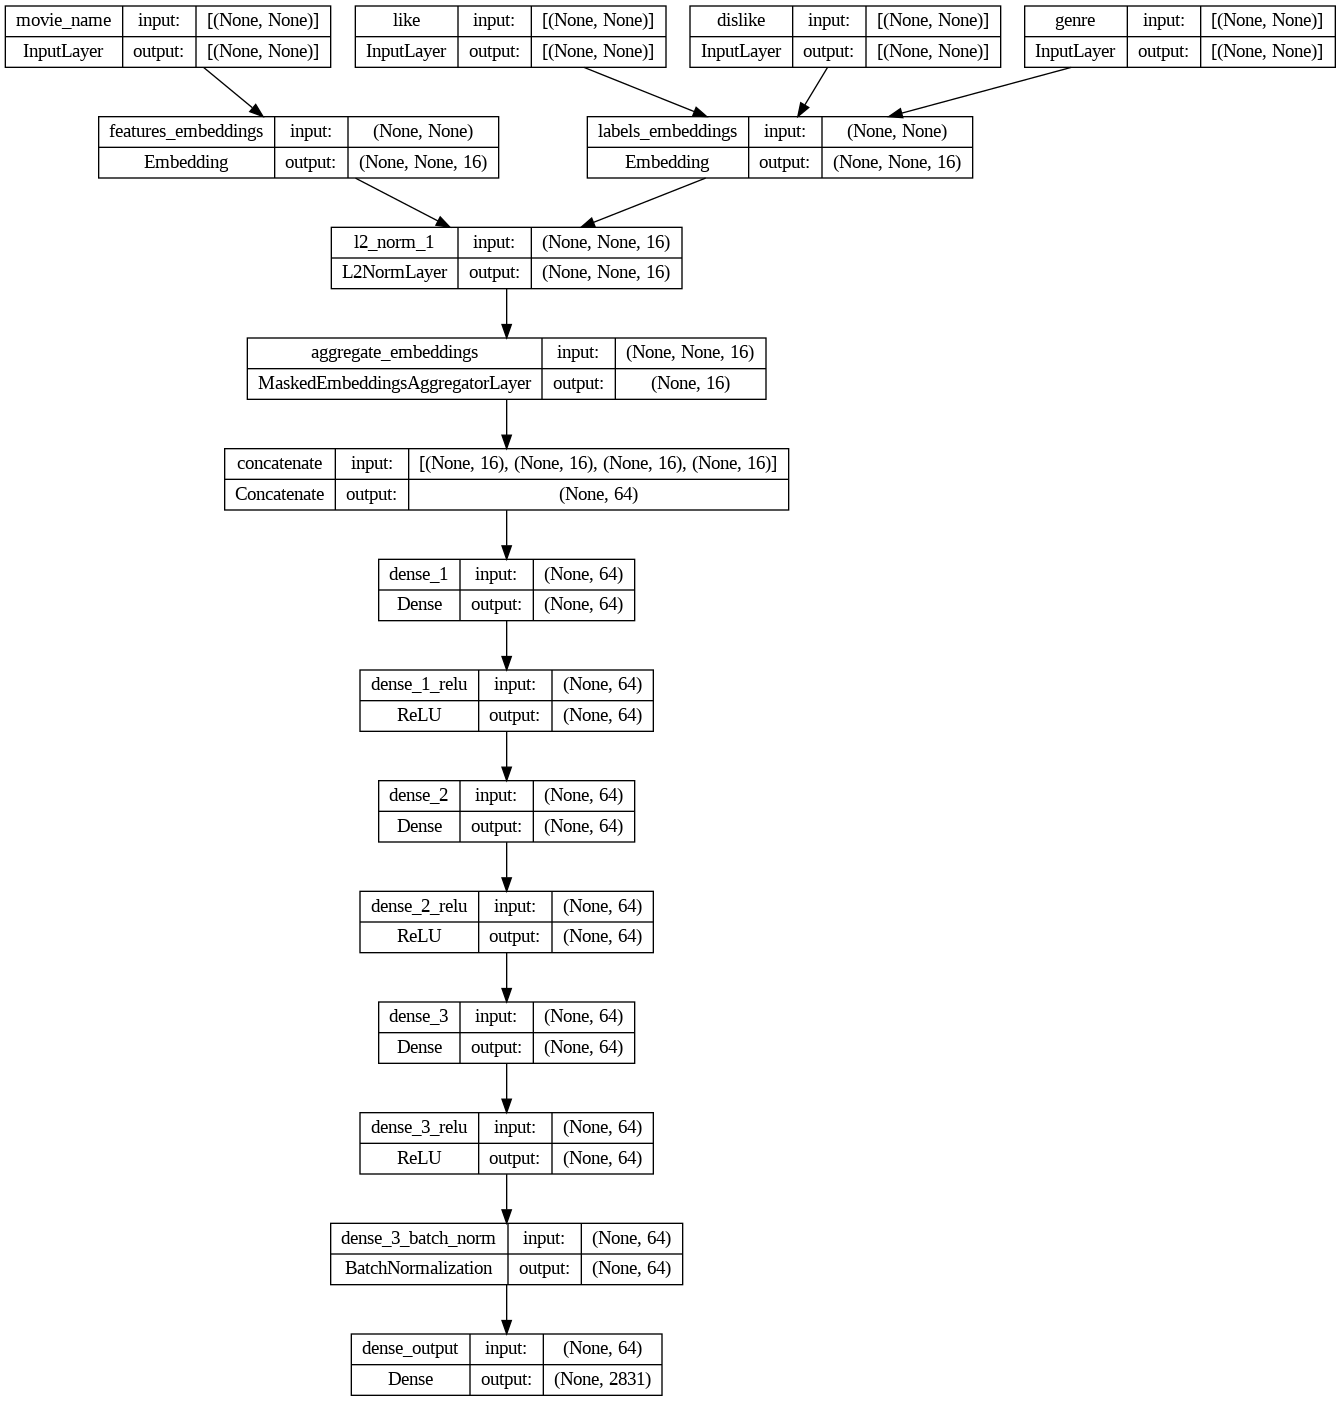

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True,dpi=96)

In [ ]:
history = model.fit([tf.keras.preprocessing.sequence.pad_sequences(user_title_list_e['title_d']),
           tf.keras.preprocessing.sequence.pad_sequences(user_title_list_e['like']),
           tf.keras.preprocessing.sequence.pad_sequences(user_title_list_e['dislike'])
           ,
            tf.keras.preprocessing.sequence.pad_sequences(user_title_list_e['all_genres'])
           ],user_title_list_e['predict_labels'].values,callbacks=[tensorboard_callback],
           steps_per_epoch=1, epochs=200,verbose=1)

Train on 1 samples
Epoch 1/200
1/1 [==============================] - 7s 7s/step - batch: 0.0000e+00 - size: 1.0000 - loss: 7.9486 - accuracy: 0.0000e+00
Epoch 2/200
1/1 [==============================] - 0s 132ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 7.9045 - accuracy: 0.0000e+00
Epoch 3/200
1/1 [==============================] - 0s 30ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 7.8556 - accuracy: 0.0000e+00
Epoch 4/200
1/1 [==============================] - 0s 33ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 7.7959 - accuracy: 0.0000e+00
Epoch 5/200
1/1 [==============================] - 0s 30ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 7.7249 - accuracy: 0.0000e+00
Epoch 6/200
1/1 [==============================] - 0s 30ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 7.6427 - accuracy: 0.0000e+00
Epoch 7/200
1/1 [==============================] - 0s 38ms/step - batch: 0.0000e+00 - size: 1.0000 - loss: 7.5498 - accuracy: 0.0000e+00
Epoch 8/200
1/1 [======

In [ ]:
# with a subset of the ratings
user_list_1=user_title_list[user_title_list.user>535]

user_list_1.head(10)

,user,dislike,like,title_d,all_genres,original_language,timestamp,predict_labels
536,536,"[600, 1372, 932, 1820, 39, 35, 407, 333, 45, 2...","[280, 522, 2176, 494, 40, 20, 34, 227, 760, 29...","[261, 470, 1820, 537, 446, 1172, 39, 19, 33, 2...","[9, 1, 3, 2, 8, 7, 6, 5, 0, 4]","[6, 7, 26, 5, 11, 13, 36, 15, 4, 10]","[0.13079170488108605, 0.13079179513231262, 0.1...",1593
537,537,"[91, 93, 251]","[6, 7, 8, 9, 10, 13, 70, 11, 80, 17, 18, 22, 2...","[6, 7, 8, 9, 86, 10, 13, 67, 11, 76, 88, 234, ...","[9, 1, 3, 2, 8, 7, 6, 5, 0, 4]","[6, 5, 11, 16]","[0.06140510478085159, 0.0614051411724752, 0.06...",248
538,538,[2830],"[40, 980, 227, 1201, 70, 233, 32, 276, 753, 42...","[39, 851, 211, 5, 67, 217, 31, 257, 665, 384, ...","[1, 3, 2, 8, 7, 5, 0, 4]","[6, 11, 5]","[0.23622047438947277, 0.23622051660375615, 0.2...",103
539,539,[2228],"[231, 153, 320, 1082, 269, 266]","[215, 143, 296, 465, 1857, 250, 247, 67]","[1, 2, 8, 6, 5, 4]","[6, 11]","[0.5508556920399785, 0.5508557502665763, 0.550...",70
540,540,[1116],"[215, 299, 130, 546, 72, 261, 315, 216, 76]","[199, 230, 121, 968, 490, 69, 242, 291, 200, 7...","[1, 3, 2, 8, 7, 6, 5, 0, 4]","[6, 7, 11, 5]","[0.27246779211392147, 0.27246816767547716, 0.2...",68
541,541,"[923, 2544, 1248, 640, 602]","[2015, 1969, 85, 77, 93, 263, 269, 262, 259, 1...","[808, 1692, 2114, 1652, 80, 74, 88, 244, 250, ...","[1, 3, 2, 8, 7, 6, 5, 0, 4]","[6, 16, 11, 5, 21, 9]","[0.8581806695139638, 0.8581817277823784, 0.858...",505
542,542,[2830],"[236, 478, 86, 151, 211, 238, 276, 487, 212, 2...","[220, 432, 81, 141, 196, 222, 257, 440, 197, 2...","[9, 1, 3, 2, 8, 7, 6, 5, 0, 4]","[11, 6, 10, 5, 16, 21]","[0.11249301541026738, 0.11249301977726221, 0.1...",484
543,543,[2830],"[7, 72, 474, 233, 348, 86, 20, 113, 224, 75, 2...","[7, 69, 428, 217, 322, 81, 19, 107, 208, 72, 2...","[9, 1, 3, 2, 8, 7, 6, 5, 0, 4]","[6, 26, 11, 5, 7, 16, 36, 3, 24, 15, 13, 37, 3...","[0.9405544109265832, 0.9405544152935781, 0.940...",2548
544,544,"[107, 1659, 1557, 260, 279, 786, 21, 1610, 1632]","[76, 333, 596, 2549, 144, 559, 1497, 959, 103,...","[73, 307, 533, 2118, 134, 5, 1275, 833, 97, 13...","[9, 1, 3, 2, 8, 7, 6, 5, 0, 4]","[6, 5, 11, 15, 16]","[0.21676709325806118, 0.21676827380233119, 0.2...",227
545,545,[1],"[203, 142, 521, 2, 0, 118, 43, 225, 1419, 70, ...","[189, 132, 469, 2, 0, 1, 110, 42, 209, 1212, 6...","[1, 3, 2, 8, 7, 6, 5, 0, 4]","[16, 6, 4, 11, 12, 7, 5]","[0.7437385842479035, 0.7437386104498724, 0.743...",1344


In [ ]:
# # test data with all the ratings
# user_list_1=user_title_list[user_title_list.user>1636538]

# user_list_1.head(10)

In [ ]:

model.save("candidate_generation.h5")

In [ ]:


predict =model.predict([tf.keras.preprocessing.sequence.pad_sequences(user_list_1['title_d']),
          tf.keras.preprocessing.sequence.pad_sequences(user_list_1['like']),
          tf.keras.preprocessing.sequence.pad_sequences(user_list_1['dislike']),
          tf.keras.preprocessing.sequence.pad_sequences(user_list_1['all_genres'])
          ])


In [ ]:
predict

array([[5.3103868e-05, 5.1095289e-05, 5.8239344e-05, ..., 5.6372570e-05,
        5.2527128e-05, 5.5276218e-05],
       [1.4815811e-04, 1.4369827e-04, 1.6188557e-04, ..., 1.6288435e-04,
        1.6320210e-04, 1.7227436e-04],
       [7.5304917e-05, 7.0162256e-05, 8.3741383e-05, ..., 7.3579002e-05,
        7.4405376e-05, 7.3133589e-05],
       ...,
       [6.9454909e-05, 6.9388501e-05, 7.4579606e-05, ..., 7.3869523e-05,
        7.1857561e-05, 7.5321514e-05],
       [7.3467359e-05, 6.4907079e-05, 7.2986870e-05, ..., 6.8205729e-05,
        6.8686481e-05, 7.0914619e-05],
       [1.2025210e-04, 1.0561805e-04, 1.1966198e-04, ..., 1.1201692e-04,
        1.1820623e-04, 1.1227467e-04]], dtype=float32)

In [ ]:
# candidate generation:
###### user top-10
N = 10
k = np.sort((-predict).argsort()[:,:N])
print(k)
# k = k.flatten()
# k[k>rating_details_sample["movie"] .max()]=0
# #k[k>data["movie"].max()]=0
# k = np.unique(k)

[[  28  103  190 ...  602  981 2195]
 [  30   58   86 ...  269  728  801]
 [   7   65   89 ...  384  762 1127]
 ...
 [  96  133  186 ...  835  866 1149]
 [  77   89  136 ...  269  798  827]
 [   7   40  197 ...  602  729 2088]]


In [ ]:
user_ids = range(1, k.shape[0] + 1)  # Generate user IDs (assuming 1-based indexing)
columns = [f'Recommendation_{i+1}' for i in range(k.shape[1])]  # Column names for recommendations
df = pd.DataFrame(k, index=user_ids, columns=columns)

 # Merge the 10 columns into a single column with a list of values
df['Recommendations'] = df.apply(lambda row: row.tolist(), axis=1)

# Drop the original 10 recommendation columns
df.drop(columns=columns, inplace=True)

# Display the modified DataFrame
print(df)

                                       Recommendations
1    [28, 103, 190, 236, 287, 348, 518, 602, 981, 2...
2      [30, 58, 86, 116, 154, 192, 211, 269, 728, 801]
3       [7, 65, 89, 99, 107, 166, 195, 384, 762, 1127]
4      [7, 61, 68, 99, 166, 199, 683, 762, 1367, 1408]
5    [30, 53, 159, 188, 276, 401, 510, 557, 686, 1526]
..                                                 ...
131      [7, 75, 78, 79, 256, 269, 508, 516, 696, 728]
132  [77, 222, 236, 348, 498, 598, 602, 618, 1249, ...
133  [96, 133, 186, 244, 277, 498, 652, 835, 866, 1...
134   [77, 89, 136, 154, 166, 211, 263, 269, 798, 827]
135   [7, 40, 197, 207, 236, 383, 387, 602, 729, 2088]

[135 rows x 1 columns]


In [ ]:
# Create a function to map video IDs to genres
def map_video_ids_to_genres(video_ids):
    # Split genres based on comma and convert to list
    genres = []
    for video_id in video_ids:
        # Find matching genre(s) for the video_id
        matching_genre = movies.loc[movies['movieId'] == video_id, 'all_genres'].values
        if len(matching_genre) > 0:
            # Split and extend the list of genres (if multiple genres)
            genres.extend(matching_genre[0].split(','))
    return genres

# Apply the function to create a new 'genre' column in user_videos_df
df['genre'] = df['Recommendations'].apply(map_video_ids_to_genres)

# Display the updated DataFrame
print(df)

                                       Recommendations  Similarity_Count  \
0    [28, 103, 190, 236, 287, 348, 518, 602, 981, 2...                 3   
1      [30, 58, 86, 116, 154, 192, 211, 269, 728, 801]                 3   
2       [7, 65, 89, 99, 107, 166, 195, 384, 762, 1127]                 2   
3      [7, 61, 68, 99, 166, 199, 683, 762, 1367, 1408]                 3   
4    [30, 53, 159, 188, 276, 401, 510, 557, 686, 1526]                 3   
..                                                 ...               ...   
130      [7, 75, 78, 79, 256, 269, 508, 516, 696, 728]                 3   
131  [77, 222, 236, 348, 498, 598, 602, 618, 1249, ...                 2   
132  [96, 133, 186, 244, 277, 498, 652, 835, 866, 1...                 1   
133   [77, 89, 136, 154, 166, 211, 263, 269, 798, 827]                 2   
134   [7, 40, 197, 207, 236, 383, 387, 602, 729, 2088]                 1   

     user                                              genre  
0     536  [2,  21, 14, 

In [ ]:
# Compute number of items in each list

liked = user_list_1

liked ['liked_videos'] = liked ['all_genres'].apply(lambda x: len(x))


In [ ]:
liked

,user,dislike,like,title_d,all_genres,original_language,timestamp,predict_labels,liked_videos
0,536,"[600, 1372, 932, 1820, 39, 35, 407, 333, 45, 2...","[280, 522, 2176, 494, 40, 20, 34, 227, 760, 29...","[261, 470, 1820, 537, 446, 1172, 39, 19, 33, 2...","[9, 1, 3, 2, 8, 7, 6, 5, 0, 4]","[6, 7, 26, 5, 11, 13, 36, 15, 4, 10]","[0.13079170488108605, 0.13079179513231262, 0.1...",1593,10
1,537,"[91, 93, 251]","[6, 7, 8, 9, 10, 13, 70, 11, 80, 17, 18, 22, 2...","[6, 7, 8, 9, 86, 10, 13, 67, 11, 76, 88, 234, ...","[9, 1, 3, 2, 8, 7, 6, 5, 0, 4]","[6, 5, 11, 16]","[0.06140510478085159, 0.0614051411724752, 0.06...",248,10
2,538,[2830],"[40, 980, 227, 1201, 70, 233, 32, 276, 753, 42...","[39, 851, 211, 5, 67, 217, 31, 257, 665, 384, ...","[1, 3, 2, 8, 7, 5, 0, 4]","[6, 11, 5]","[0.23622047438947277, 0.23622051660375615, 0.2...",103,8
3,539,[2228],"[231, 153, 320, 1082, 269, 266]","[215, 143, 296, 465, 1857, 250, 247, 67]","[1, 2, 8, 6, 5, 4]","[6, 11]","[0.5508556920399785, 0.5508557502665763, 0.550...",70,6
4,540,[1116],"[215, 299, 130, 546, 72, 261, 315, 216, 76]","[199, 230, 121, 968, 490, 69, 242, 291, 200, 7...","[1, 3, 2, 8, 7, 6, 5, 0, 4]","[6, 7, 11, 5]","[0.27246779211392147, 0.27246816767547716, 0.2...",68,9
...,...,...,...,...,...,...,...,...,...
130,666,"[489, 408, 32, 9]","[8, 6, 7, 91, 11, 19, 12, 14, 29, 16, 17, 15, ...","[8, 6, 7, 86, 11, 5, 12, 14, 28, 16, 17, 15, 2...","[9, 1, 3, 2, 8, 7, 6, 5, 0, 4]","[6, 5, 11, 13, 4, 23, 15]","[0.08387426558373716, 0.0838742670394021, 0.08...",426,10
131,667,[2830],"[1042, 112, 264, 113, 227, 277, 7, 20, 70]","[904, 106, 245, 107, 211, 258, 7, 19, 67, 257]","[1, 2, 8, 7, 5, 0, 4]","[6, 26]","[0.2968991499590697, 0.2968993872324556, 0.296...",276,7
132,668,[394],"[86, 29, 1094, 42, 683, 138, 72, 148, 777]","[81, 361, 28, 949, 41, 610, 128, 69, 138, 688,...","[9, 1, 3, 2, 8, 6, 5, 0, 4]","[6, 7, 13, 11]","[0.32923803496510984, 0.32923814996264045, 0.3...",380,9
133,669,"[8, 704, 188]","[137, 70, 6, 40, 21, 276, 281, 20, 280, 408, 6...","[127, 67, 6, 39, 20, 257, 8, 262, 19, 626, 261...","[9, 1, 3, 2, 8, 6, 5, 0, 4]","[6, 11, 26, 5]","[0.2170823218687923, 0.21708320400174871, 0.21...",421,9


In [ ]:
# Reset indices if needed
df.reset_index(drop=True, inplace=True)
liked.reset_index(drop=True, inplace=True)

In [ ]:
def count_similar_items(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    return len(set1 & set2)  # Count of common elements

# Apply the custom function to corresponding cells of the two columns
df['Similarity_Count'] = df.apply(lambda row: count_similar_items(row['genre'], liked.loc[row.name]['all_genres']), axis=1)

# Display the updated DataFrame
print(df)

                                       Recommendations  Similarity_Count  \
0    [28, 103, 190, 236, 287, 348, 518, 602, 981, 2...                 3   
1      [30, 58, 86, 116, 154, 192, 211, 269, 728, 801]                 3   
2       [7, 65, 89, 99, 107, 166, 195, 384, 762, 1127]                 2   
3      [7, 61, 68, 99, 166, 199, 683, 762, 1367, 1408]                 3   
4    [30, 53, 159, 188, 276, 401, 510, 557, 686, 1526]                 3   
..                                                 ...               ...   
130      [7, 75, 78, 79, 256, 269, 508, 516, 696, 728]                 3   
131  [77, 222, 236, 348, 498, 598, 602, 618, 1249, ...                 2   
132  [96, 133, 186, 244, 277, 498, 652, 835, 866, 1...                 1   
133   [77, 89, 136, 154, 166, 211, 263, 269, 798, 827]                 2   
134   [7, 40, 197, 207, 236, 383, 387, 602, 729, 2088]                 1   

     user                                              genre  
0     536  [2,  21, 14, 

In [ ]:
df['user'] = liked['user']

In [ ]:
df

,Recommendations,Similarity_Count,user,genre,total,recall,genre_liked,precision,f1_score
0,"[28, 103, 190, 236, 287, 348, 518, 602, 981, 2...",3,536,"[2, 21, 14, 2, 2, 5, 4, 5, 4, 3, 11, 18...",10,0.300000,"[9, 1, 3, 2, 8, 7, 6, 5, 0, 4]",0.230769,0.260870
1,"[30, 58, 86, 116, 154, 192, 211, 269, 728, 801]",3,537,"[6, 1, 20, 16, 11, 2, 4, 2, 18, 14, 4, ...",10,0.300000,"[9, 1, 3, 2, 8, 7, 6, 5, 0, 4]",0.200000,0.240000
2,"[7, 65, 89, 99, 107, 166, 195, 384, 762, 1127]",2,538,"[2, 20, 11, 5, 2, 18, 14, 2, 4, 5, 5, 4,...",8,0.250000,"[1, 3, 2, 8, 7, 5, 0, 4]",0.200000,0.222222
3,"[7, 61, 68, 99, 166, 199, 683, 762, 1367, 1408]",3,539,"[5, 1, 5, 2, 2, 4, 5, 1, 11, 20, 18, 20...",6,0.500000,"[1, 2, 8, 6, 5, 4]",0.230769,0.315789
4,"[30, 53, 159, 188, 276, 401, 510, 557, 686, 1526]",3,540,"[6, 1, 5, 2, 2, 5, 5, 2, 4, 2, 16, 11, 2...",9,0.333333,"[1, 3, 2, 8, 7, 6, 5, 0, 4]",0.300000,0.315789
...,...,...,...,...,...,...,...,...,...
130,"[7, 75, 78, 79, 256, 269, 508, 516, 696, 728]",3,666,"[5, 16, 1, 1, 2, 18, 2, 20, 11, 15, 2, ...",10,0.300000,"[9, 1, 3, 2, 8, 7, 6, 5, 0, 4]",0.250000,0.272727
131,"[77, 222, 236, 348, 498, 598, 602, 618, 1249, ...",2,667,"[12, 18, 7, 15, 2, 5, 4, 3, 11, 18, 1, ...",7,0.285714,"[1, 2, 8, 7, 5, 0, 4]",0.142857,0.190476
132,"[96, 133, 186, 244, 277, 498, 652, 835, 866, 1...",1,668,"[11, 5, 14, 7, 2, 18, 14, 12, 11, 20, 2...",9,0.111111,"[9, 1, 3, 2, 8, 6, 5, 0, 4]",0.071429,0.086957
133,"[77, 89, 136, 154, 166, 211, 263, 269, 798, 827]",2,669,"[12, 18, 20, 11, 2, 3, 11, 20, 1, 18, 2,...",9,0.222222,"[9, 1, 3, 2, 8, 6, 5, 0, 4]",0.142857,0.173913


In [ ]:
df['total'] = liked['liked_videos']

In [ ]:
df

,Recommendations,Similarity_Count,user,genre,total
0,"[28, 103, 190, 236, 287, 348, 518, 602, 981, 2...",3,536,"[2, 21, 14, 2, 2, 5, 4, 5, 4, 3, 11, 18...",10
1,"[30, 58, 86, 116, 154, 192, 211, 269, 728, 801]",3,537,"[6, 1, 20, 16, 11, 2, 4, 2, 18, 14, 4, ...",10
2,"[7, 65, 89, 99, 107, 166, 195, 384, 762, 1127]",2,538,"[2, 20, 11, 5, 2, 18, 14, 2, 4, 5, 5, 4,...",8
3,"[7, 61, 68, 99, 166, 199, 683, 762, 1367, 1408]",3,539,"[5, 1, 5, 2, 2, 4, 5, 1, 11, 20, 18, 20...",6
4,"[30, 53, 159, 188, 276, 401, 510, 557, 686, 1526]",3,540,"[6, 1, 5, 2, 2, 5, 5, 2, 4, 2, 16, 11, 2...",9
...,...,...,...,...,...
130,"[7, 75, 78, 79, 256, 269, 508, 516, 696, 728]",3,666,"[5, 16, 1, 1, 2, 18, 2, 20, 11, 15, 2, ...",10
131,"[77, 222, 236, 348, 498, 598, 602, 618, 1249, ...",2,667,"[12, 18, 7, 15, 2, 5, 4, 3, 11, 18, 1, ...",7
132,"[96, 133, 186, 244, 277, 498, 652, 835, 866, 1...",1,668,"[11, 5, 14, 7, 2, 18, 14, 12, 11, 20, 2...",9
133,"[77, 89, 136, 154, 166, 211, 263, 269, 798, 827]",2,669,"[12, 18, 20, 11, 2, 3, 11, 20, 1, 18, 2,...",9


In [ ]:
df['genre_liked'] = liked['all_genres']

In [ ]:
df

,Recommendations,Similarity_Count,user,genre,total,recall,genre_liked
0,"[28, 103, 190, 236, 287, 348, 518, 602, 981, 2...",3,536,"[2, 21, 14, 2, 2, 5, 4, 5, 4, 3, 11, 18...",10,0.300000,"[9, 1, 3, 2, 8, 7, 6, 5, 0, 4]"
1,"[30, 58, 86, 116, 154, 192, 211, 269, 728, 801]",3,537,"[6, 1, 20, 16, 11, 2, 4, 2, 18, 14, 4, ...",10,0.300000,"[9, 1, 3, 2, 8, 7, 6, 5, 0, 4]"
2,"[7, 65, 89, 99, 107, 166, 195, 384, 762, 1127]",2,538,"[2, 20, 11, 5, 2, 18, 14, 2, 4, 5, 5, 4,...",8,0.250000,"[1, 3, 2, 8, 7, 5, 0, 4]"
3,"[7, 61, 68, 99, 166, 199, 683, 762, 1367, 1408]",3,539,"[5, 1, 5, 2, 2, 4, 5, 1, 11, 20, 18, 20...",6,0.500000,"[1, 2, 8, 6, 5, 4]"
4,"[30, 53, 159, 188, 276, 401, 510, 557, 686, 1526]",3,540,"[6, 1, 5, 2, 2, 5, 5, 2, 4, 2, 16, 11, 2...",9,0.333333,"[1, 3, 2, 8, 7, 6, 5, 0, 4]"
...,...,...,...,...,...,...,...
130,"[7, 75, 78, 79, 256, 269, 508, 516, 696, 728]",3,666,"[5, 16, 1, 1, 2, 18, 2, 20, 11, 15, 2, ...",10,0.300000,"[9, 1, 3, 2, 8, 7, 6, 5, 0, 4]"
131,"[77, 222, 236, 348, 498, 598, 602, 618, 1249, ...",2,667,"[12, 18, 7, 15, 2, 5, 4, 3, 11, 18, 1, ...",7,0.285714,"[1, 2, 8, 7, 5, 0, 4]"
132,"[96, 133, 186, 244, 277, 498, 652, 835, 866, 1...",1,668,"[11, 5, 14, 7, 2, 18, 14, 12, 11, 20, 2...",9,0.111111,"[9, 1, 3, 2, 8, 6, 5, 0, 4]"
133,"[77, 89, 136, 154, 166, 211, 263, 269, 798, 827]",2,669,"[12, 18, 20, 11, 2, 3, 11, 20, 1, 18, 2,...",9,0.222222,"[9, 1, 3, 2, 8, 6, 5, 0, 4]"


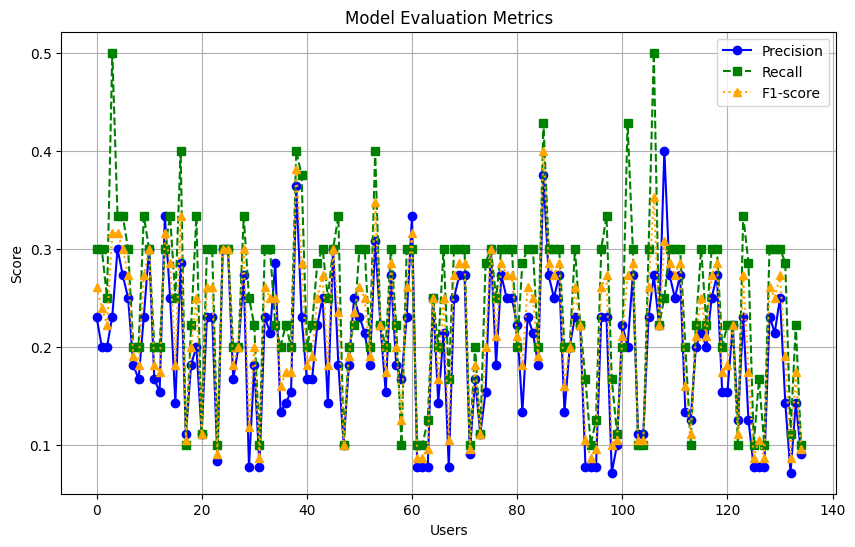

In [ ]:
def precision(row):
    recommended_genres = row['genre']
    liked_genres = row['genre_liked']
    if not recommended_genres:
        return 0.0
    recommended_set = set(recommended_genres)
    liked_set = set(liked_genres)
    correct_recommendations = recommended_set & liked_set
    return len(correct_recommendations) / len(recommended_set)

def recall(row):
    recommended_genres = row['genre']
    liked_genres = row['genre_liked']
    if not liked_genres:
        return 0.0
    recommended_set = set(recommended_genres)
    liked_set = set(liked_genres)
    correct_recommendations = recommended_set & liked_set
    return len(correct_recommendations) / len(liked_set)

def f1_score(row):
    precision_val = precision(row)
    recall_val = recall(row)
    if precision_val + recall_val == 0:
        return 0.0
    return 2 * (precision_val * recall_val) / (precision_val + recall_val)

# Compute evaluation metrics
df['precision'] = df.apply(precision, axis=1)
df['recall'] = df.apply(recall, axis=1)
df['f1_score'] = df.apply(f1_score, axis=1)

# Plot evaluation results
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['precision'], label='Precision', marker='o', linestyle='-', color='blue')
plt.plot(df.index, df['recall'], label='Recall', marker='s', linestyle='--', color='green')
plt.plot(df.index, df['f1_score'], label='F1-score', marker='^', linestyle=':', color='orange')
plt.xlabel('Users')
plt.ylabel('Score')
plt.title('Model Evaluation Metrics')
plt.legend()
plt.grid(True)
plt.show()
